In [3]:
# Step 0: Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [8]:
# Step 1: Load the dataset from local CSV file
df = pd.read_csv('yellow_tripdata_2016-02.csv')
# df.head()
print(df.columns)


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [9]:
features = [
    'passenger_count',
    'trip_distance',
    'fare_amount',
    'tip_amount',
    'total_amount'
]

# Convert datetime columns to pandas datetime type
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Calculate trip duration in minutes
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

# Extract pickup hour (0-23)
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

# Then add these to your features list
features += ['trip_duration', 'pickup_hour']


['passenger_count',
 'trip_distance',
 'fare_amount',
 'tip_amount',
 'total_amount',
 'trip_duration',
 'pickup_hour']

In [10]:
#  Drop rows with missing values in selected features
df_clean = df.dropna(subset=features)

In [11]:
# Filter unrealistic data
mask = (
    (df_clean['passenger_count'] > 0) &
    (df_clean['trip_distance'] > 0) &
    (df_clean['trip_duration'] > 0) &
    (df_clean['fare_amount'] >= 0) &
    (df_clean['total_amount'] >= 0)
)
df_clean = df_clean.loc[mask]

In [12]:
#Extract feature matrix
X = df_clean[features].values

In [13]:
# Scale features (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
# Fit Gaussian Mixture Model with 3 clusters
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(X_scaled)


,n_components,3
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,42


In [15]:
# Predict cluster labels
labels = gmm.predict(X_scaled)
df_clean['cluster'] = labels

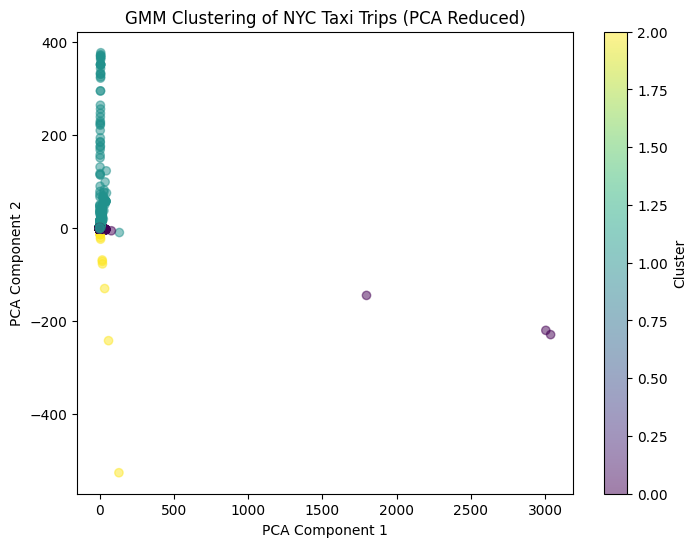

In [17]:
# Visualize clusters in 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('GMM Clustering of NYC Taxi Trips (PCA Reduced)')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [23]:
# Analyze clusters by mean feature values
cluster_summary = df_clean.groupby('cluster')[features].mean()
print("\nCluster feature averages:")
print(cluster_summary)
print(df_clean['cluster'].value_counts())




Cluster feature averages:
         passenger_count  trip_distance  fare_amount  tip_amount  \
cluster                                                            
0               1.158238       2.159133    10.055507    1.378868   
1               2.475100       9.354016    31.302029    4.855749   
2               4.594119      26.051430     7.750510    1.103115   

         total_amount  trip_duration  pickup_hour  
cluster                                            
0           12.554923      11.169261    13.680567  
1           39.752156      50.416901    13.491081  
2            9.962838       8.685014    13.964791  
cluster
0    8831841
1    1356753
2    1121916
Name: count, dtype: int64


In [19]:
#Save clustered data to CSV
df_clean.to_csv('nyc_taxi_trips_with_clusters.csv', index=False)